# Classifying Images using Data Augmentation

## Introduction

In this notebook, you learn how to set up preprocessing to ensure reproducibility in production, and then delve into ways to implement a variety of preprocessing operations in Keras/TensorFlow. You also learn how to carry out data augmentation to improve the model's resilience and accuracy.

### Learning Objectives


* Understand how to set up preprocessing to ensure reproducibility in production.

* Understand how to carry out data augmentation to improve the model's resilience and accuracy.


Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_using_data_augmentation.ipynb).

Creating training datasets for machine learning is the first step of the standard image processing pipeline. The next stage is preprocessing the raw images in order to feed them to the model for training or inference. Before raw images can be fed into an image model, they usually have to be preprocessed. Such preprocessing has several, overlapping goals: shape transformation, data quality, and model quality.

Data augmentation can be effectively used to train the deep learning models. Some of the simple transformations applied to the image are; geometric transformations such as Flipping, Rotation, Translation, Cropping and Scaling.

In [1]:
!pip install --upgrade tensorflow-estimator==2.6.0

Please ignore any incompatibility warnings and errors and re-run the cell to view the installed tensorflow version.

In [2]:
# Import and print the installed version of TensorFlow
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
print(tf.version.VERSION)
IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3

2.6.5


#### Defining Helper Functions

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

## Reading TF Records
To read TensorFlow records, use a tf.data.TFRecordDataset.

The dataset at this point contains protobufs. You need to parse the protobufs based on the schema of the records. Specify that schema by using feature_description. The label and label_int have fixed length (1), but the image and its shape are variable length (because they are arrays).

Given the proto and the feature description (or schema), you can read in the data using the function parse_single_example: rec = tf.io.parse_single_example(proto, feature_description). For storage efficiency, variable length arrays are stored as SparseTensors. You can make them dense and reshape the flattened image array into a 3D tensor which gives you the full parsing function: read_from_tfr(self, proto). You can now apply the above parsing function to every proto that is read using map():

`train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ]).map(parse_tfr)`

At this point, the training dataset gives you the image and its label that you can use as obtained from the CSV dataset.

2023-10-07 04:11:00.438963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-10-07 04:11:00.439019: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-07 04:11:00.439048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20231007-092821): /proc/driver/nvidia/version does not exist
2023-10-07 04:11:00.441966: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

(240, 320, 3)
tf.Tensor(0.3526376, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847906, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729625, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.27678293, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305466, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


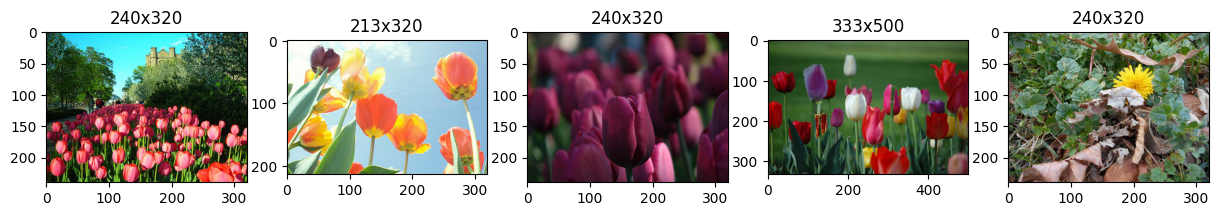

In [4]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(
        proto, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label_int = rec['label_int']
    return img, label_int

train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ], compression_type='GZIP').map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('{}x{}'.format(img.shape[0], img.shape[1]))

## Resizing and other preprocessing layers
One of the key reasons to preprocess images is to ensure that the image tensors have the shape expected by the Input layer of the ML model. In order to do so, you can change the size and/or resolution of the images being read in.
#### Keras Preprocessing Layer
Keras has a preprocessing layer that offers resizing all the images to our desired height and width. Create a Sequential model that contains all our preprocessing operations by using resizing(). To apply the preprocessing layer to the image, you could do: train_dataset.map(lambda img: preproc_layers(img)). However, this won’t work because the train_dataset provides a tuple (img, label) where the image is a 3D tensor (height, width, channels) while the Keras Sequential model expects a 4D tensor (batchsize, height, width, channels).

The simplest solution is to write a function that adds an extra dimension to the image at the first axis using expand_dims() and removes the batch dimension from the result using squeeze(). apply_preproc(img, label) function performs this.

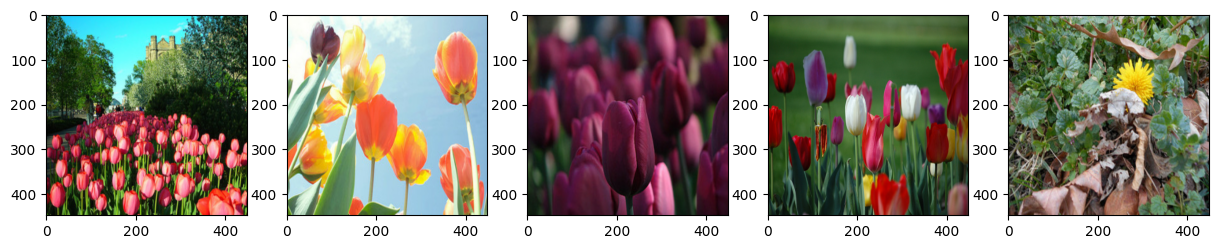

In [5]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## TensorFlow Image Module
[tf.image module](https://www.tensorflow.org/api_docs/python/tf/image) offers a plethora of image processing functions. In the realm of resizing, TensorFlow allows to retain the aspect ratio when resizing by cropping the image to the desired aspect ratio and stretching it.

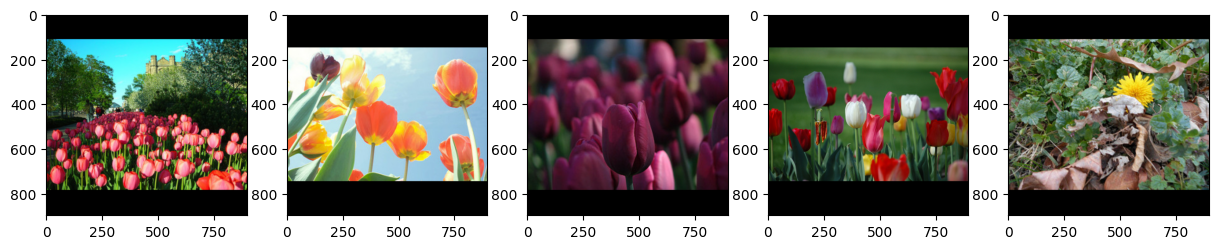

In [6]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## Mixing Keras and TensorFlow
A center cropping function is available in TensorFlow. You can also mix the TensorFlow resize_with_pad and Keras’ CenterCrop functionality.

In order to call an arbitrary set of TensorFlow functions as part of a Keras model, wrap the function(s) inside a Keras Lambda layer.


## Preprocessor
This class contains preprocessing functions that have to be explicitly applied between training and prediction.

Note that the very first layer within the Sequential carries an input_shape parameter. Because the input images are in different sizes, you specify the height and width as None, which leaves the values to be determined at runtime, but do specify that there will always be 3 channels.

In [7]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        #TODO 1: Resize and pad the image to a target width and height.
        #Your code here
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

## Data augmentation

Preprocessing is useful beyond simply reformatting images to the size and shape required by the model. Preprocessing can also be a way to improve model quality through data augmentation.

Keras [supports](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/) several data augmentation layers, including RandomTranslation, RandomRotation, RandomZoom, RandomCrop, RandomFlip, and so on. They all work similarly.

The RandomFlip layer randomly flips the image or keep it in its original orientation during training time. The image is passed through unchanged during inference. Keras does this automatically – all yee need to add as one of the layers in our model.

Any preprocessing code added to the Keras model is automatically applied during prediction. Therefore, you can take the center cropping functionality out of the Preprocessor class and move it into the model itself.

Note that the first layer of a Sequential layer is the one that carries the input_shape parameter. Therefore, remove the input_shape from the Hub layer and put it on the CenterCrop. Specify the desired size of the image if the input to the CenterCrop is different than the desired size of the images.

When you do a center crop, you lose a considerable part of the image. To improve the training performance, you could consider augmenting the data by taking random crops of the desired size from the input image. The RandomCrop layer in Keras does random crops during training (so that the model sees different parts of the image during each epoch, although some of them now include the padded edges and may not even include the flowers that are of interest) and behave like a CenterCrop during inference.

Training this model is similar to training without augmentation. However, you need to train the model longer whenever you augment data.


In [10]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

#PATTERN_SUFFIX='-0000*'
#NUM_EPOCHS=3

PATTERN_SUFFIX='-*'
NUM_EPOCHS=20

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]
    
    # TODO 2: Define Sequential model
    #Your code here
    model = tf.keras.Sequential(layers, name='flower_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model

In [ ]:
model = train_and_evaluate()

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/20
92/92 [==============================] - 74s 766ms/step - loss: 0.7683 - accurac

In [ ]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

In [ ]:
## but actually, for prediction, you won't have TensorFlow Records.
## this is how you'd predict for individual images
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

Congrats! You've completed the lab!